In [2]:
#pip install requests pymongo schedule tqdm psycopg2 pymongo psycopg2-binary


In [1]:
from datetime import datetime, timedelta
import pandas as pd
import requests
import pymongo
import schedule
import time
from tqdm import tqdm
from collections import OrderedDict


# Load stock tickers from a CSV file
data = pd.read_csv("/Users/zdz/Downloads/sp500_companies.csv")
tickers = data['Symbol'].unique()
ticker_list = tickers.tolist()

In [2]:
import sys
print(sys.executable)


/usr/local/bin/python3


In [5]:
# get ticker list for first 10 
ticker_list

['MSFT',
 'AAPL',
 'NVDA',
 'AMZN',
 'GOOG',
 'GOOGL',
 'META',
 'BRK-B',
 'LLY',
 'AVGO']

In [6]:
# MongoDB setup
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["5400Final"]  # Database name

In [7]:
from datetime import datetime, timedelta
import requests
from tqdm import tqdm
from collections import OrderedDict
import time
import schedule


# API details
url = "https://yfinance-stock-market-data.p.rapidapi.com/price-customdate"
headers = {
	"content-type": "application/x-www-form-urlencoded",
	"X-RapidAPI-Key": "adc30321e3msh9519a803e296a70p1150a2jsne7e28e57f358",
	"X-RapidAPI-Host": "yfinance-stock-market-data.p.rapidapi.com"
}

# Rate Limiting
request_count = 0
DAILY_LIMIT = 1000

def reset_request_count():
    global request_count
    request_count = 0

def update_daily():
    global request_count
    for ticker in tqdm(ticker_list, desc="Fetching data"):
        if request_count >= DAILY_LIMIT:
            print("Daily request limit reached. Waiting until reset...")
            break
        # MongoDB collection for this ticker
        mongo_collection = mongo_db[ticker]

        # Adjust the date range for the last 30 days data, including today
        today = datetime.now()
        start_date = today - timedelta(days=30)  # 30 days before today
        end_date = today  # Or use today - timedelta(days=1) for yesterday

        # Format the dates
        start_date_str = start_date.strftime("%Y-%m-%d")
        end_date_str = end_date.strftime("%Y-%m-%d")

        # API request payload
        payload = f"symbol={ticker}&end={end_date_str}&start={start_date_str}"

        # Fetch data from the API
        response = requests.request("POST", url, data=payload, headers=headers)
        request_count += 1
        
        if response.status_code == 200:
            data = response.json().get('data')
            if not data:
                continue  # Skip if no data is returned
            for day_data in data:  # Process each day's data
                # Prepare the document to insert/update
                document = OrderedDict([
                    ("date", datetime.fromtimestamp(day_data['Date'] / 1000).strftime('%m-%d-%Y')),
                    ("date_utc", day_data['Date']),
                    ("open", day_data['Open']),
                    ("high", day_data['High']),
                    ("low", day_data['Low']),
                    ("close", day_data['Close']),
                    ("volume", day_data['Volume']),
                    ("adjclose", day_data['Adj Close'])
                ])

                # Upsert the document in MongoDB
                mongo_collection.update_one(
                    {"date": document["date"]},
                    {"$set": document},
                    upsert=True
                )
        else:
            print(f"Error retrieving data for {ticker}: {response.status_code}")
        
        # Sleep to adhere to rate limit
        time.sleep(0.2)  # Adjust as per the API's rate limiting policy

# Schedule the request counter reset at midnight
schedule.every().day.at("00:00").do(reset_request_count)

# Schedule to run at 16:00 every day
schedule.every().day.at("16:00").do(update_daily)

# Initial run to populate the database
update_daily()

# Keep the script running to adhere to the schedule
print("Scheduler started. Waiting to run at scheduled times...")
while True:
    schedule.run_pending()
    time.sleep(60)  # Check every minute

        


Fetching data: 100%|██████████| 503/503 [05:08<00:00,  1.63it/s]


Scheduler started. Waiting to run at scheduled times...


KeyboardInterrupt: 

In [7]:
import psycopg2
import pymongo

In [8]:
# MongoDB setup
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["5400_Final"]  # Database name

In [10]:
# Create connection to PostgreSQL
pg_conn = psycopg2.connect(
    host="localhost",
    database="5400_Final",
    user="postgres",
    password="123"
)

cur = pg_conn.cursor()

cur.execute("SELECT version();")

db_version = cur.fetchone()

print(f"Database version: {db_version[0]}")



Database version: PostgreSQL 16.2 (Debian 16.2-1.pgdg120+2) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


In [12]:
# Assuming mongo_db and pg_conn are already defined and connected to your MongoDB and PostgreSQL.

for ticker in ticker_list:
    pg_data = []  # Reset the pg_data for each ticker

    # Retrieve data from MongoDB collection
    mongo_collection = mongo_db[ticker]
    mongo_data = list(mongo_collection.find())

    # Transform data to the desired format
    for row in mongo_data[1:]:  # Assuming the first row is headers or irrelevant
        pg_row = {
            "date": row["date"],
            "open": row["open"],
            "high": row["high"],
            "low": row["low"],
            "close": row["close"],
            "volume": row["volume"],
            "adj_close": row.get("adjclose", row.get("adj_close"))  # Handle potential key variations
        }
        pg_data.append(pg_row)

    # Define table_name for PostgreSQL using the current ticker, and quote it if it's a reserved word
    table_name = ticker.upper().replace("-", "_")
    # Check for reserved SQL keywords 'ALL' and 'ON'
    if table_name in ['ALL', 'ON']:
        quoted_table_name = f'"{table_name.lower()}"'
    else:
        quoted_table_name = table_name

    with pg_conn.cursor() as pg_cur:
        # Create the table if it doesn't exist
        pg_cur.execute(f"""
            CREATE TABLE IF NOT EXISTS {quoted_table_name} (
                date DATE PRIMARY KEY,
                open FLOAT,
                high FLOAT,
                low FLOAT,
                close FLOAT,
                volume BIGINT,
                adj_close FLOAT
            )
        """)

        # Prepare the INSERT INTO statement with placeholders for the actual values
        insert_statement = f"""
            INSERT INTO {quoted_table_name} (
                date, open, high, low, close, volume, adj_close
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s
            ) ON CONFLICT (date) DO UPDATE SET
                open = EXCLUDED.open,
                high = EXCLUDED.high,
                low = EXCLUDED.low,
                close = EXCLUDED.close,
                volume = EXCLUDED.volume,
                adj_close = EXCLUDED.adj_close
        """

        # Execute the insert statement for each row in pg_data
        for row in pg_data:
            pg_cur.execute(insert_statement, (
                row['date'],
                row['open'],
                row['high'],
                row['low'],
                row['close'],
                row['volume'],
                row['adj_close']
            ))

        # Commit the transaction to make sure changes are saved
        pg_conn.commit()


In [ ]:
#!pip install pandas numpy matplotlib seaborn psycopg2

  Using cached psycopg2-2.9.9.tar.gz (384 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      running egg_info
      writing psycopg2.egg-info/PKG-INFO
      writing dependency_links to psycopg2.egg-info/dependency_links.txt
      writing top-level names to psycopg2.egg-info/top_level.txt
      
      Error: pg_config executable not found.
      
      pg_config is required to build psycopg2 from source.  Please add the directory
      containing pg_config to the $PATH or specify the full executable path with the
      option:
      
          python setup.py build_ext --pg-config /path/to/pg_config build ...
      
      or with the pg_config option in 'setup.cfg'.
      
      If you prefer to avoid building psycopg2 from source, please install the PyPI
      'psycopg2-binary' package inst

In [ ]:
#!pip install matplotlib


  Using cached matplotlib-3.8.4-cp311-cp311-macosx_10_12_x86_64.whl.metadata (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 5.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 908.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 621.1 kB/s eta 0:00:0000:01:01


In [ ]:
#!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [15]:
# Connect to PostgreSQL database
pg_conn = psycopg2.connect(
    host="localhost",
    database="5400_Final",
    user="postgres",
    password="123"
)

In [16]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


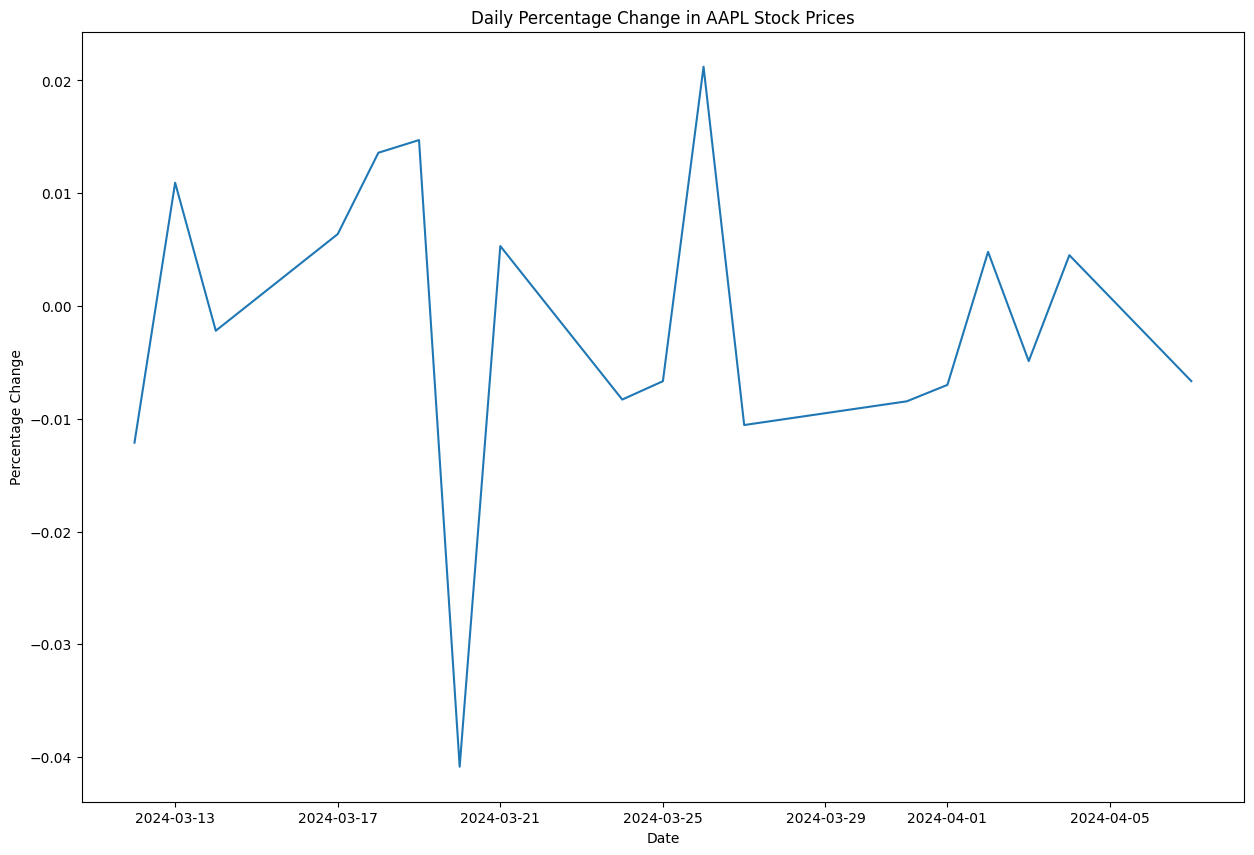

In [17]:

# Define function to retrieve data for a given ticker
def get_data(ticker):
    with pg_conn.cursor() as pg_cur:
        pg_cur.execute("SELECT * FROM {table_name} ORDER BY date ASC".format(table_name=ticker))
        rows = pg_cur.fetchall()
    return pd.DataFrame(rows, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])


# Define function to calculate daily percentage change in stock prices
def daily_pct_change(df):
    return df['adj_close'].pct_change()

# Define function to plot the daily percentage change in stock prices
def plot_pct_change(df, ticker):
    plt.figure(figsize=(15,10))
    sns.lineplot(x='date', y='pct_change', data=df)
    plt.title("Daily Percentage Change in {} Stock Prices".format(ticker))
    plt.xlabel("Date")
    plt.ylabel("Percentage Change")
    plt.show()

# Example usage
df = get_data('AAPL') 
df['pct_change'] = daily_pct_change(df)
plot_pct_change(df, 'AAPL')

In [21]:
pip install --upgrade nbformat

  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4bc3cba53c9f038ab6e9ed964e22f1/nbformat-5.10.4-py3-none-any.whl.metadata
  Obtaining dependency information for fastjsonschema>=2.15 from https://files.pythonhosted.org/packages/9c/b9/79691036d4a8f9857e74d1728b23f34f583b81350a27492edda58d5604e1/fastjsonschema-2.19.1-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema>=2.6 from https://files.pythonhosted.org/packages/39/9d/b035d024c62c85f2e2d4806a59ca7b8520307f34e0932fbc8cc75fe7b2d9/jsonschema-4.21.1-py3-none-any.whl.metadata
  Obtaining dependency information for attrs>=22.2.0 from https://files.pythonhosted.org/packages/e0/44/827b2a91a5816512fcaf3cc4ebc465ccd5d598c45cefa6703fcf4a79018f/attrs-23.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema-specifications>=2023.03.6 from https://files.pythonhosted.org/packages/ee/07/44bd408781594c4d0a027666ef27fab1e441

In [18]:
import plotly.express as px

# Define function to plot the daily percentage change in stock prices using Plotly for interactivity
def plot_pct_change_plotly(df, ticker):
    fig = px.line(df, x='date', y='pct_change', title=f"Daily Percentage Change in {ticker} Stock Prices")
    fig.update_layout(xaxis_title='Date', yaxis_title='Percentage Change', title_x=0.5)
    fig.show()

# Assuming get_data and daily_pct_change functions are defined as above

# Example usage with Plotly
df = get_data('AAPL') 
df['pct_change'] = daily_pct_change(df)
plot_pct_change_plotly(df, 'AAPL')


In [24]:
pip install sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
   

In [19]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:


import pandas as pd
import numpy as np


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define function to prepare data for classification model
def prepare_data(df):
    X = df[['open', 'high', 'low', 'close', 'volume', 'adj_close']].values[:-1]
    y = np.where(df['adj_close'].shift(-1) > df['adj_close'], 1, 0)[:-1]
    return X, y

# Define function to train and test a decision tree classification model
def train_test_model(df):
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Example usage
df = get_data('AAPL')
accuracy = train_test_model(df)
print("Accuracy of decision tree model for AAPL: {:.2f}%".format(accuracy * 100))

Accuracy of decision tree model for AAPL: 50.00%


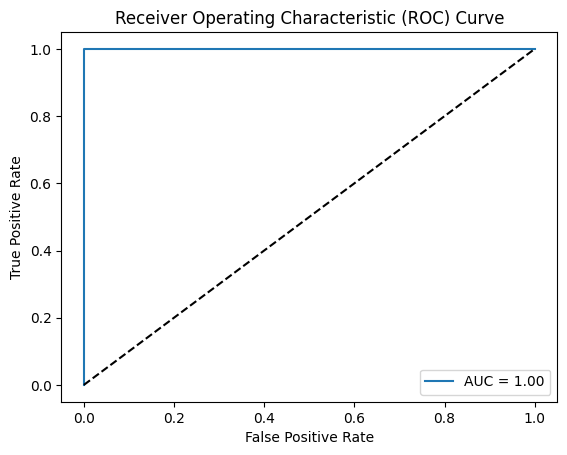

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels and predicted probabilities
true_labels = np.array([0, 0, 1, 1, 0, 1])
predicted_probs = np.array([0.2, 0.3, 0.6, 0.8, 0.4, 0.7])

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Compute the AUC (Area Under the Curve)
auc_score = auc(fpr, tpr)

# Plot the AOC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
############################################################################################################
##################################   Flask   #############################################################

In [21]:
pip install Flask

Note: you may need to restart the kernel to use updated packages.


In [32]:
from flask import Flask, render_template
import psycopg2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import io
import base64

In [38]:
app = Flask(__name__)


# Set up PostgreSQL connection
pg_conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="5400_Final",
    user="postgres",
    password="123"
)

In [39]:
@app.route("/")
def home():
    return render_template("home.html")

In [40]:
###  need to edit based on 1 month data here.
@app.route("/results/<ticker>")
def results(ticker):
    # Retrieve data from PostgreSQL
    with pg_conn.cursor() as pg_cur:
        pg_cur.execute("""
            SELECT date, open, high, low, close, volume, adj_close
            FROM {table_name}
        """.format(table_name=ticker.upper()))
        pg_data = pg_cur.fetchall()

    # Perform analysis
    max_price = max(pg_data, key=lambda x: x[2])
    min_price = min(pg_data, key=lambda x: x[3])
    avg_price = sum([row[4] for row in pg_data]) / len(pg_data)

    # Prepare data for plotting
    x = [i for i in range(len(pg_data))]
    y = [row[4] for row in pg_data]

    # Train linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit([[i] for i in range(len(pg_data))], y)

    # Predict future stock prices using linear regression
    future_x = [[i] for i in range(len(pg_data), len(pg_data) + 500)]
    future_y = lin_reg.predict(future_x)

    # Plot predicted stock prices
    fig = plt.figure()
    plt.plot(x, y)
    plt.plot(future_x, future_y)
    plt.xlabel("Time (days)")
    plt.ylabel("Closing Price ($)")
    plt.title("Predicted Stock Price Trend for {}".format(ticker.upper()))
    plt.legend(["Historical Data", "Predicted Data"])
    
    # Convert plot to base64 for displaying in HTML
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.close()

    # Render results page with analysis results and predicted stock price chart
    return render_template("results.html", ticker=ticker.upper(), max_price=max_price, min_price=min_price,
                           avg_price=avg_price, image_base64=image_base64)

In [29]:
if __name__ == "__main__":
    app.run(debug=True, use_reloader=False, port = 5001)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [70]:
from flask import Flask, render_template, request, redirect, url_for
import psycopg2
from datetime import datetime, timedelta
import base64
import io
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import numpy as np

app = Flask(__name__)

# Set up PostgreSQL connection
pg_conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="5400_Final",
    user="postgres",
    password="123"
)

@app.route("/", methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        ticker = request.form['ticker']
        return redirect(url_for('results', ticker=ticker))
    return render_template("home.html")

@app.route("/results/<ticker>")
def results(ticker):
    # Calculate the date 30 days ago from today
    date_30_days_ago = datetime.now() - timedelta(days=30)

    # Retrieve data from PostgreSQL for the last 30 days
    with pg_conn.cursor() as pg_cur:
        query = """
            SELECT date, open, high, low, close, volume, adj_close
            FROM {table_name}
            WHERE date >= %s
        """.format(table_name=ticker.upper())
        pg_cur.execute(query, [date_30_days_ago])
        pg_data = pg_cur.fetchall()

    if not pg_data:
        return "No data available for this ticker in the last 30 days."

    # Perform analysis, round to 3 decimal places
    max_price_data = max(pg_data, key=lambda x: x[2])
    min_price_data = min(pg_data, key=lambda x: x[3])
    max_price = (max_price_data[0], round(max_price_data[2], 3))
    min_price = (min_price_data[0], round(min_price_data[3], 3))
    avg_price = round(sum([row[4] for row in pg_data]) / len(pg_data), 3)



    # Prepare data for plotting
    x = [i for i in range(len(pg_data))]
    y = [row[4] for row in pg_data]

    # Train and predict using a decision tree model
    model = train_decision_tree_model(pg_data)
    future_y = predict_future_prices(model, 5)

    # Calculate the future x values starting after the last historical x value
    last_x_value = x[-1] + 1
    future_x = [last_x_value + i for i in range(5)]

    # Plotting the historical data
    fig = plt.figure()
    plt.plot(x, y, marker='o', label="Historical Data")

    # Plotting the predicted future data
    plt.plot(future_x, future_y, marker='o', linestyle='--', label="Predicted Data")

    plt.xlabel("Time (days)")
    plt.ylabel("Closing Price ($)")
    plt.title("Predicted Stock Price Trend for {}".format(ticker.upper()))
    plt.legend()

    # Convert plot to base64 for displaying in HTML
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()
    plt.close()

    # Render results page with analysis results and predicted stock price chart
    return render_template("results.html", ticker=ticker.upper(), max_price=max_price, min_price=min_price,
                        avg_price=avg_price, image_base64=image_base64)


def train_decision_tree_model(data):
    x = np.array([[i] for i in range(len(data))])
    y = np.array([row[4] for row in data])
    model = DecisionTreeRegressor()
    model.fit(x, y)
    return model

def predict_future_prices(model, days):
    future_x = np.array([[i] for i in range(len(pg_data), len(pg_data) + days)])
    future_y = model.predict(future_x)
    return future_y

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False, port=5001)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [18/Apr/2024 21:16:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2024 21:16:17] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [18/Apr/2024 21:16:18] "GET /results/aapl HTTP/1.1" 500 -
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1488, in __call__
    return self.wsgi_app(environ, start_response)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1466, in wsgi_app
    response = self.handle_exception(e)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1463, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python